In [1]:
import torch
import esm
import re
from tqdm import tqdm
import numpy as np
import pandas as pd

import benchmark_esm as besm
import benchmark_config as cfg
import h5py


%load_ext autoreload
%autoreload 2

In [135]:
test = pd.read_feather(cfg.DATADIR+'test.feather').iloc[1:10,:6]

In [136]:
test.iloc[0:10,np.r_[0,5]]

,id,seq
1,P0DQF6,MRRFVFLAFVLVLFVIANLDSSSAQVNFSPDWGQGKRSGSSDTCAV...
2,P0DQF5,MAVILKHLAIILLVFVIEIKMGQGSQIERRSSGVTHEMLSSISKPE...
3,P0DQF4,MKIIALLLMVFLDFIIVNXAEQNEKKRRDNLGIPGAGDTEDANQAY...
4,P0DQF3,MFFLGFIIVCASEEQSDNRLPNIDFGLDRGHSGRMTAEYLMGLAAA...
5,P0DQF2,MKSVIFALFLVYLLIVRAAEANENIGLGLDRGSSGTIAAKQQMGIE...
6,P0DQF1,MKKRSQVFCIFIAMVLLILPLSMSDVPEICKICGEECERFCFKRRF...
7,P0DQF0,MNSTDRLLGVLLAVVALILLIRISEANDCDLCGRECVSACGTKMFR...
8,P0DQE9,MRFLVSVAFLLTVSSLLVSGENNNPVPEDPCSKEGGVCVAVDRCPD...
9,P0DQF7,MSLIVVRTHSFLFVLVLLLFASVFHSVDSQVFNPNGRYGRRDSASA...


In [11]:
# %pip install fair-esm
import matplotlib.pyplot as plt
import esm
import torch
import os
from Bio import SeqIO
import itertools
from typing import List, Tuple
import string
import numpy as np

In [2]:
data = [ ('P0DQF6', 'MRRFVFLAFVLVLFVIANLDSSSAQVNFSPDWGQGKRSGSSDTCAVCAQTMAQVYRLLQGLEAKLGQSRNYSR')]
model, alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
batch_converter = alphabet.get_batch_converter()
batch_labels, batch_strs, batch_tokens = batch_converter(data)
if torch.cuda.is_available():
        model = model.cuda()
        print("Transferred model to GPU")

Transferred model to GPU


In [3]:
with torch.no_grad():
    results = model(batch_tokens.cuda(), repr_layers=[0,11,12], return_contacts=True)
token_representations = results["representations"][12]
token_representations[0][0].mean(0)[0:20]

tensor([-0.2881,  0.2495, -0.6946,  0.3177, -0.0616, -0.4715,  0.0322, -0.0453,
         0.3494, -0.0943,  8.0473, -0.0862, -0.2058,  0.3221, -0.8795, -0.6163,
        -0.5165,  5.9515, -0.3756,  0.5949], device='cuda:0')

In [4]:
with torch.no_grad():
    results = model(batch_tokens.cuda(), repr_layers=[0,11,12], return_contacts=True)
token_representations = results["representations"][12]
token_representations[0][0].mean(0)[0:20]

tensor([-0.1885,  0.2016, -0.5950,  0.5088, -0.0989, -0.5079, -0.0153, -0.0423,
         0.3616, -0.1095,  7.5732, -0.0150, -0.1211,  0.1983, -0.9614, -0.5896,
        -0.4696,  5.4913, -0.3458,  0.5157], device='cuda:0')

In [5]:
data = [ ('P0DQF6', 'MRRFVFLAFVLVLFVIANLDSSSAQVNFSPDWGQGKRSGSSDTCAVCAQTMAQVYRLLQGLEAKLGQSRNYSR')]
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()
batch_labels, batch_strs, batch_tokens = batch_converter(data)
if torch.cuda.is_available():
        model = model.cuda()
        print("Transferred model to GPU")

Transferred model to GPU


In [6]:
with torch.no_grad():
    results = model(batch_tokens.cuda(), repr_layers=[0,32,33], return_contacts=True)
token_representations = results["representations"][33]
token_representations[0].mean(0)[0:20]

tensor([ 0.0332,  0.1519,  0.1056,  0.0938,  0.0292, -0.2111, -0.1152, -0.0363,
        -0.1663, -0.2502,  0.1383,  0.1433, -0.1769,  0.2553,  0.1416, -0.0346,
         0.3376, -0.0178, -0.0545, -0.2098], device='cuda:0')

In [7]:
with torch.no_grad():
    results = model(batch_tokens.cuda(), repr_layers=[0,32,33], return_contacts=True)
token_representations = results["representations"][33]
token_representations[0].mean(0)[0:20]

tensor([ 0.0332,  0.1519,  0.1056,  0.0938,  0.0292, -0.2111, -0.1152, -0.0363,
        -0.1663, -0.2502,  0.1383,  0.1433, -0.1769,  0.2553,  0.1416, -0.0346,
         0.3376, -0.0178, -0.0545, -0.2098], device='cuda:0')

In [136]:
## esm-MSA-rep

In [15]:

# This is an efficient way to delete lowercase characters and insertion characters from a string
deletekeys = dict.fromkeys(string.ascii_lowercase)
deletekeys["."] = None
deletekeys["*"] = None
translation = str.maketrans(deletekeys)

def read_sequence(filename: str) -> Tuple[str, str]:
    """ Reads the first (reference) sequences from a fasta or MSA file."""
    record = next(SeqIO.parse(filename, "fasta"))
    return record.description, str(record.seq)

def remove_insertions(sequence: str) -> str:
    """ Removes any insertions into the sequence. Needed to load aligned sequences in an MSA. """
    return sequence.translate(translation)

def read_msa(filename: str, nseq: int) -> List[Tuple[str, str]]:
    """ Reads the first nseq sequences from an MSA file, automatically removes insertions."""
    return [(record.description, remove_insertions(str(record.seq)))
            for record in itertools.islice(SeqIO.parse(filename, "fasta"), nseq)]

In [132]:
msa_transformer, msa_alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
msa_transformer = msa_transformer.eval().cuda()
msa_batch_converter = msa_alphabet.get_batch_converter()

In [133]:
msa_data = [read_msa("esm/examples/P0DQF6.a3m", 64)]
msa_batch_labels, msa_batch_strs, msa_batch_tokens = msa_batch_converter(msa_data)
msa_batch_tokens = msa_batch_tokens.cuda()
print(msa_batch_tokens.size(), msa_batch_tokens.dtype)  # Should be a 3D tensor with dtype torch.int64.

torch.Size([1, 64, 74]) torch.int64


In [134]:
with torch.no_grad():
    msa= msa_transformer(msa_batch_tokens, repr_layers=[1,11,12],return_contacts=False)
msa['representations'][1][0].mean(0).mean(0)

tensor([-2.1783e-02, -5.5795e-02,  8.6698e-03, -1.6375e-01,  4.8809e-03,
         2.4309e-02,  9.2302e-02, -4.3608e-01,  1.9338e-02,  3.5768e-02,
         5.5202e-02, -9.0309e-02,  5.3810e-02,  5.9769e-02,  2.0430e-02,
         3.8092e-02, -4.0420e-02,  6.0828e-01,  9.1909e-02,  6.1771e-02,
        -5.0473e-02,  1.4681e-02, -8.0791e-02,  6.8780e-02,  2.5954e-02,
        -1.1677e-02,  3.9863e-02,  1.9743e-02,  1.7946e-02, -1.1073e-02,
        -8.7249e-02,  4.9787e-02, -9.1655e-02,  1.2455e-01, -8.3247e-02,
         1.0458e-02,  8.1226e-01, -4.6280e-01,  5.9439e-02,  6.3803e-03,
        -5.5961e-02, -7.2299e-02, -1.5499e-01,  8.6316e-02, -1.0502e-01,
        -1.5106e-01,  1.1873e-01, -7.0509e-02, -7.9012e-04, -1.8455e-01,
         9.6487e-02,  8.8619e-02,  2.9408e-02, -3.6051e-02,  5.1874e-02,
        -2.8526e-01, -1.7073e-02,  1.6495e-01, -5.5789e-02, -2.4226e-01,
         1.1123e-01, -1.0404e-01,  1.1614e-02, -3.9655e-02, -4.7088e-02,
         1.4244e-01,  7.4093e-02, -1.3705e-01, -4.7

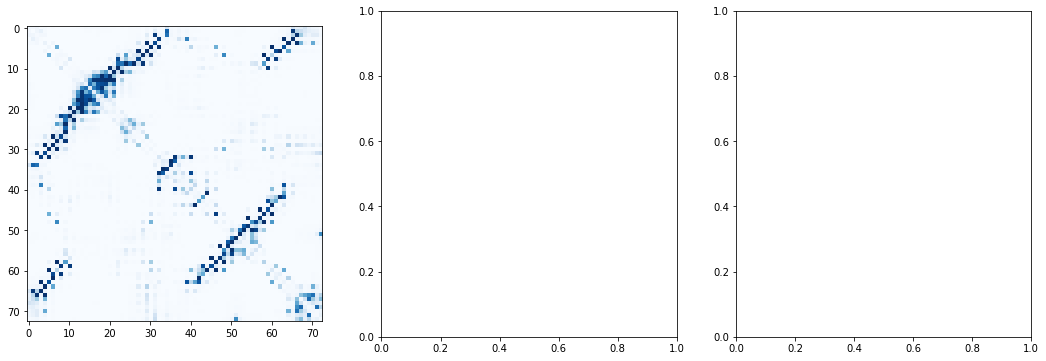

In [137]:

fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
for ax, contact, msa in zip(axes, msa_contacts, msa_batch_strs):
    seqlen = len(msa[0])
    ax.imshow(contact[:seqlen, :seqlen], cmap="Blues")
plt.show()

In [493]:
batch_labels, batch_strs, batch_tokens = batch_converter(data)

with torch.no_grad():
    results = model(batch_tokens.cuda(), repr_layers=[0,11,12], return_contacts=True)
token_representations = results["representations"][12]

In [494]:
token_representations

tensor([[[[ 0.0648,  0.2570,  0.1799,  ..., -0.1871, -0.2356, -0.3614],
          [-0.3320, -0.8348,  0.2987,  ..., -0.2413, -1.7200, -1.3359],
          [ 0.1971,  0.3281,  0.2372,  ..., -1.3308,  0.0075, -1.1294],
          ...,
          [-0.6285, -0.1563, -0.6227,  ..., -0.4411,  0.0740,  0.1096],
          [ 0.0349, -0.2286, -0.4893,  ..., -0.6404, -0.2472, -1.1922],
          [-0.4498, -0.2806, -0.3482,  ..., -1.3575,  0.3403, -0.6521]]]],
       device='cuda:0')

In [80]:
token_representations = results["representations"][12]

In [81]:
sequence_representations = []
for i, (_, seq) in enumerate(data):
    sequence_representations.append(token_representations[i, 1 : len(seq) + 1].mean(0))

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [133]:
def get_rep_multi_sequence(sequences, model='esm_msa1b_t12_100M_UR50S', repr_layers=[0, 32, 33], seqthres=1022):
    """[对多个序列进行embedding]
    Args:
        sequences ([DataFrame]): [ sequence info]]
        seqthres (int, optional): [description]. Defaults to 1022.

    Returns:
        [DataFrame]: [final_rep0, final_rep32, final_rep33]
    """
    final_label_list = []
    final_rep0 =[]
    final_rep32 =[]
    final_rep33 =[]
    seq ='SGGYLNGDVDVDDGELKDPETGKLWKSPVRIPCCNKIFSRKIIEDKLIDSDFTCPSCGKEQIYLDTLVADEELQAKVDEYVKNLSENK'

    model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
    batch_converter = alphabet.get_batch_converter()
    if torch.cuda.is_available():
            model = model.cuda()
            print("Transferred model to GPU")

    for i in tqdm(range(len(sequences))):
        apd = get_rep_single_seq(
            seqid = sequences.iloc[i].id, 
            sequence=sequences.iloc[i].seq, 
            model=model, 
            batch_converter=batch_converter, 
            seqthres=seqthres)

        final_label_list.append(np.array(apd['label']))
        final_rep0.append(np.array(apd['mean_representations'][0]))
        final_rep32.append(np.array(apd['mean_representations'][32]))
        final_rep33.append(np.array(apd['mean_representations'][33])) 

    final_rep0 = pd.DataFrame(final_rep0)
    final_rep32 = pd.DataFrame(final_rep32)
    final_rep33 = pd.DataFrame(final_rep33)
    final_rep0.insert(loc=0, column='id', value=np.array(final_label_list).flatten())
    final_rep32.insert(loc=0, column='id', value=np.array(final_label_list).flatten())
    final_rep33.insert(loc=0, column='id', value=np.array(final_label_list).flatten())

    col_name = ['id']+ ['f'+str(i) for i in range (1,final_rep0.shape[1])]
    final_rep0.columns = col_name
    final_rep32.columns = col_name
    final_rep33.columns = col_name

    return final_rep0, final_rep32, final_rep33

In [138]:
get_rep_multi_sequence(sequences=test.iloc[0:10,np.r_[0,5]], model='esm_msa1b_t12_100M_UR50S', repr_layers=[0, 32, 33], seqthres=1022)

  0%|          | 0/9 [00:00<?, ?it/s]

Transferred model to GPU


NameError: name 'get_rep_single_seq' is not defined

In [213]:
def cut_text(text,lenth):
    """[将字符串拆分成固定长度]

    Args:
        text ([string]): [input string]
        lenth ([int]): [sub_sequence length]

    Returns:
        [string list]: [string results list]
    """
    textArr = re.findall('.{'+str(lenth)+'}', text) 
    textArr.append(text[(len(textArr)*lenth):]) 
    return textArr 

In [377]:
def get_rep_single_seq(seqid, sequence, model,model_name, batch_converter, repr_layers, seqthres=1022):
    """[对单个序列进行embedding]

    Args:
        seqid ([string]): [sequence name]]
        sequence ([sting]): [sequence]
        model ([model]): [ embedding model]]
        batch_converter ([object]): [description]
        seqthres (int, optional): [max sequence length]. Defaults to 1022.

    Returns:
        [type]: [description]
    """
    
    if len(sequence) < seqthres:
        data =[(seqid, sequence)]
    else:
        seqArray = cut_text(sequence, seqthres)
        data=[]
        for item in seqArray:
            data.append((seqid, item))
    
    MINI_SIZE = len(data)   
    
    result ={}

    for i in range(MINI_SIZE): 
        batch_labels, batch_strs, batch_tokens = batch_converter([data[i]])
        if torch.cuda.is_available():
            batch_tokens = batch_tokens.to(device="cuda", non_blocking=True)
        
        with torch.no_grad():
            results = model(batch_tokens, repr_layers=repr_layers, return_contacts=False)    
    
        representations = {layer: t.to(device="cpu") for layer, t in results["representations"].items()}  
        
        result["label"] = batch_labels[0]
        
        if i ==0:
            if model_name=='ESM-1b':
                result["mean_representations"] = {layer: t[i, 1 : len(batch_strs[0]) + 1].mean(0).clone() for layer, t in representations.items()}
            if model_name=='ESM-MSA-1b':
                result["mean_representations"] = {layer: t[0][0].mean(0).clone() for layer, t in representations.items()}
        else:
                        
            if model_name == 'ESM-1b':
                result["mean_representations"] += {layer: t[i, 1 : len(batch_strs[0]) + 1].mean(0).clone() for layer, t in representations.items()}[layer]
            if model_name=='ESM-MSA-1b':
                result["mean_representations"] = dict(list(result["mean_representations"].items()) + list({layer: t[0][0].mean(0).clone() for layer, t in representations.items()}.items()))

    for index, layer in enumerate(repr_layers):
        result["mean_representations"][layer] = result["mean_representations"][layer] /MINI_SIZE
    
    return result



In [328]:
model, alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
batch_converter = alphabet.get_batch_converter()
if torch.cuda.is_available():
        model = model.cuda()
        print("Transferred model to GPU")

Transferred model to GPU


In [382]:
apd = get_rep_single_seq(
    seqid = test.iloc[0].id, 
    sequence=test.iloc[0].seq, 
    model=model, 
    model_name='ESM-MSA-1b',
    batch_converter=batch_converter, 
    repr_layers=[1,11,12],
    seqthres=1022)


In [325]:
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()
if torch.cuda.is_available():
        model = model.cuda()
        print("Transferred model to GPU")

Transferred model to GPU


In [327]:
apd = get_rep_single_seq(
    seqid = test.iloc[0].id, 
    sequence=test.iloc[0].seq, 
    model=model, 
    model_name='ESM-1b',
    batch_converter=batch_converter, 
    repr_layers=[0,32,33],
    seqthres=1022)
apd

{'label': 'P0DQF6',
 'mean_representations': {0: tensor([-0.2595,  0.0069, -0.0054,  ..., -0.0048, -0.0646,  0.1329]),
  32: tensor([0.8595, 2.5502, 1.2462,  ..., 3.5109, 6.1667, 2.1148]),
  33: tensor([0.0351, 0.1553, 0.1030,  ..., 0.1049, 0.0888, 0.0769])}}

In [844]:
SEQTHRES = 1022
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()
if torch.cuda.is_available():
        model = model.cuda()
        print("Transferred model to GPU")
test = pd.read_feather(cfg.DATADIR+'test.feather').iloc[1:10,:6]

rep0, rep32, rep33 = besm.get_rep_multi_sequence(sequences=test, seqthres=SEQTHRES)
rep0.to_feather(cfg.DATADIR + 'rep0.feather')
rep32.to_feather(cfg.DATADIR + 'rep32.feather')
rep33.to_feather(cfg.DATADIR + 'rep33.feather')

Transferred model to GPU


 44%|████▍     | 4/9 [00:00<00:00, 37.81it/s]

Transferred model to GPU


100%|██████████| 9/9 [00:00<00:00, 37.53it/s]


ValueError: feather must have string column names

In [850]:
rep0.columns = rep0.columns.astype(str)
rep0.to_feather(cfg.DATADIR + 'rep0.feather')

In [846]:
rep0.columns = col_name

In [845]:
col_name = ['id']+ ['f'+str(i) for i in range (1,rep0.shape[1])]

In [849]:
rep0.id[0]

'P0DQF6'

In [843]:
rep32.id[0]

array('P0DQF6', dtype='<U6')

In [76]:
x7 = torch.load('esm/examples/some_proteins_msa1b/res3.pt')
x7

{'label': ['UniRef50_A0A1E3NP16'],
 'representations': {0: tensor([], size=(0, 429, 768)),
  11: tensor([], size=(0, 429, 768)),
  12: tensor([], size=(0, 429, 768))},
 'mean_representations': {0: tensor([[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]),
  11: tensor([[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]),
  12: tensor([[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  .

In [65]:
x6 = torch.load('esm/examples/some_proteins_msa1b/res.pt')
x6

{'label': ['UniRef50_A0A1E3NP16', 'UniRef50_UPI000836A30F'],
 'mean_representations': {0: tensor([[ 0.1617,  0.0713, -0.1128,  ...,  0.0194, -0.4979,  0.1176],
          [ 0.1339, -0.2066,  0.0634,  ...,  0.6929,  0.3400,  0.0035],
          [ 0.1252,  0.0094,  0.1757,  ...,  0.2891,  0.0215,  0.0433],
          ...,
          [ 0.3081, -0.0973, -0.0136,  ...,  0.1779,  0.4491,  0.1290],
          [-0.1625, -0.1539, -0.0341,  ...,  0.0496, -0.1954,  0.0660],
          [ 0.3333, -1.1156, -0.0992,  ...,  0.2736, -0.0076, -0.0065]]),
  11: tensor([[ 0.9353,  2.7420,  5.1430,  ...,  0.1818, -2.2292, -2.6881],
          [-0.7071,  0.1708,  5.2029,  ...,  0.7310, -3.6499, -2.9498],
          [-1.5353, -0.4901,  7.2462,  ...,  0.0979,  1.3164, -5.7652],
          ...,
          [-5.5800, -3.6247, -0.7781,  ...,  1.3050, -4.7842,  3.4947],
          [-5.0885, -4.6765, -0.4935,  ...,  1.7730, -0.9909,  1.6749],
          [-1.3126, -2.6082,  0.4834,  ...,  2.0109, -4.3899,  0.5080]]),
  12: tens

In [73]:
x6['mean_representations']

{0: tensor([[ 0.1617,  0.0713, -0.1128,  ...,  0.0194, -0.4979,  0.1176],
         [ 0.1339, -0.2066,  0.0634,  ...,  0.6929,  0.3400,  0.0035],
         [ 0.1252,  0.0094,  0.1757,  ...,  0.2891,  0.0215,  0.0433],
         ...,
         [ 0.3081, -0.0973, -0.0136,  ...,  0.1779,  0.4491,  0.1290],
         [-0.1625, -0.1539, -0.0341,  ...,  0.0496, -0.1954,  0.0660],
         [ 0.3333, -1.1156, -0.0992,  ...,  0.2736, -0.0076, -0.0065]]),
 11: tensor([[ 0.9353,  2.7420,  5.1430,  ...,  0.1818, -2.2292, -2.6881],
         [-0.7071,  0.1708,  5.2029,  ...,  0.7310, -3.6499, -2.9498],
         [-1.5353, -0.4901,  7.2462,  ...,  0.0979,  1.3164, -5.7652],
         ...,
         [-5.5800, -3.6247, -0.7781,  ...,  1.3050, -4.7842,  3.4947],
         [-5.0885, -4.6765, -0.4935,  ...,  1.7730, -0.9909,  1.6749],
         [-1.3126, -2.6082,  0.4834,  ...,  2.0109, -4.3899,  0.5080]]),
 12: tensor([[-1.1448e-01,  3.1971e-01,  5.7256e-01,  ..., -5.0704e-02,
          -2.6226e-01, -1.3852e-01],


In [753]:
sq ="AVIYYRFRSQKPDHIATIKFDGTGLTVFELKRDIILANNLLHSTDVDIVLYSTEDIQDTKSWGYQNGGSATNGDEDDMIKKMFSVQDEQWSQQQDVMATATRVDNFRTNVNEPVPEYYICYKCGEKGKHHIKNCPKNNDPNWEGVRVRKTTGIPKSHLKAIENPEDTIRDSNSSGNTTYMVNDEGKYVVAVADTKAWEKYQKTKKGESGGYLNGDVDVDDG\
ELKDPETGKLWKSPVRIPCCNKIFSRKIIEDKLIDSDFTCPSCGKEQIYLDTLVADEELQAKVDEYVKNLSENKNNDGNSPKRRQVNPAGATANTSQLPQIPMMPMPPINMQMPPMNIGMPPFMPFMPMPGMNPAVIYYRFRSQKPDHIATIKFDGTGLTVFELKRDIILANNLLHSTDVDIVLYSTEDIQDTKSWGYQNGGSSSAGERELDDDNEVVPRSTTVLVR\
RTMTPKKNKGNVQRYVAGKPRLQVSGTNSVNKSISLGNNVGGTMNFGDAATNGDEDDMIKKMFSVQDEQWSQQQDVMATATRVDNFRTNVNEPVPEYYICYKCGEKGKHHIKNCPKNNDPNWEGVRVRKTTGIPKSHLKAIENPEDTIRDSNSSGNTTYMVNDEGKYVVAVADTKAWEKYQKTKKGESGGYLNGDVDVDDGELKDPETGKLWKSPVRIPCCNKIFSRK\
IIEDKLIDSDFTCPSCGKEQIYLDTLVADEELQAKVDEYVKNLSENKNNDGNSPKRRQVNPAGATANTSQLPQIPMMPMPPINMQMPPMNIGMPPFMPFMPMPGMNPAVIYYRFRSQKPDHIATIKFDGTGLTVFELKRDIILANNLLHSTDVDIVLYSTEDIQDTKSWGYQNGGSSSAGERELDDDNEVVPRSTTVLVRRTMTPKKNKGNVQRYVAGKPRLQVSGTNSVNKSISLGNNVGGTMNFGDAATNGDEDDMIKKMFSVQDEQWSQQ"

In [777]:
def get_rep_single_seq(seqid, sequence):
    
    if len(sequence) < SEQTHRES:
        data =[(seqid, sequence)]
    else:
        seqArray = cut_text(sequence, SEQTHRES)
        data=[]
        for item in seqArray:
            data.append((seqid, item))
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    
    if torch.cuda.is_available():
        batch_tokens = batch_tokens.to(device="cuda", non_blocking=True)
        
    REP_LAYERS = [0, 32, 33]    
    MINI_SIZE = len(batch_labels)
    
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=REP_LAYERS, return_contacts=False)    
    

    representations = {layer: t.to(device="cpu") for layer, t in results["representations"].items()}
    result={}
    result["label"] = batch_labels[0]

    for i in range(MINI_SIZE):
        if i ==0:
            result["mean_representations"] = {layer: t[i, 1 : len(batch_strs[0]) + 1].mean(0).clone() for layer, t in representations.items()}
        else:
            for index, layer in enumerate(REP_LAYERS):
                result["mean_representations"][layer] += {layer: t[i, 1 : len(batch_strs[0]) + 1].mean(0).clone() for layer, t in representations.items()}[layer]

    for index, layer in enumerate(REP_LAYERS):
        result["mean_representations"][layer] = result["mean_representations"][layer] /MINI_SIZE
    
    return result

In [778]:
apd = get_rep_single_seq(seqid = 'aeq', sequence=seq2) 

In [779]:
final_label_list.append(apd['label'])
final_rep0.append(np.array(apd['mean_representations'][0]))
final_rep32.append(np.array(apd['mean_representations'][32]))
final_rep33.append(np.array(apd['mean_representations'][33]))

In [780]:
pd.DataFrame(final_rep32)

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,13.342666,-6.065397,-7.653386,-0.206877,3.412858,8.580017,-4.474588,7.195158,-15.528293,3.261242,...,26.182968,9.536174,-0.349252,2.056357,-38.834545,-5.067162,-4.019046,-13.059695,5.651593,9.056581
1,13.342666,-6.065397,-7.653386,-0.206877,3.412858,8.580017,-4.474588,7.195158,-15.528293,3.261242,...,26.182968,9.536174,-0.349252,2.056357,-38.834545,-5.067162,-4.019046,-13.059695,5.651593,9.056581
2,13.342666,-6.065397,-7.653386,-0.206877,3.412858,8.580017,-4.474588,7.195158,-15.528293,3.261242,...,26.182968,9.536174,-0.349252,2.056357,-38.834545,-5.067162,-4.019046,-13.059695,5.651593,9.056581
3,8.866100,-8.275290,-7.363873,0.169422,-0.941267,3.683374,-4.503125,7.027940,-10.004908,3.117211,...,19.919933,9.000986,-0.117662,4.793332,-25.503050,-1.988137,-3.524633,-11.511133,5.617582,5.462593
4,8.866100,-8.275290,-7.363873,0.169422,-0.941267,3.683374,-4.503125,7.027940,-10.004908,3.117211,...,19.919933,9.000986,-0.117662,4.793332,-25.503050,-1.988137,-3.524633,-11.511133,5.617582,5.462593


In [747]:
batch_labels, batch_strs, batch_tokens = batch_converter(data)
if torch.cuda.is_available():
    batch_tokens = batch_tokens.to(device="cuda", non_blocking=True)
    
REP_LAYERS = [0, 32, 33]    
MINI_SIZE = len(batch_labels)


with torch.no_grad():
    results = model(batch_tokens, repr_layers=REP_LAYERS, return_contacts=False)    
    

representations = {layer: t.to(device="cpu") for layer, t in results["representations"].items()}
result["label"] = batch_labels[0]

for i in range(MINI_SIZE):
    if i ==0:
        result["mean_representations"] = {layer: t[i, 1 : len(batch_strs[0]) + 1].mean(0).clone() for layer, t in representations.items()}
    else:
        for index, layer in enumerate(REP_LAYERS):
            result["mean_representations"][layer] += {layer: t[i, 1 : len(batch_strs[0]) + 1].mean(0).clone() for layer, t in representations.items()}[layer]

for index, layer in enumerate(REP_LAYERS):
    result["mean_representations"][layer] = result["mean_representations"][layer] /MINI_SIZE

print(result)
apd = result.copy()


final_label_list.append(apd['label'])
final_rep0.append(np.array(apd['mean_representations'][0]))
final_rep32.append(np.array(apd['mean_representations'][32]))
final_rep33.append(np.array(apd['mean_representations'][33]))


{'label': 'UniRef50_A0A1E3NP16', 'mean_representations': {0: tensor([-0.0515, -0.0002,  0.0142,  ...,  0.0084, -0.0568,  0.0050]), 32: tensor([ 13.3427,  -6.0654,  -7.6534,  ..., -13.0597,   5.6516,   9.0566]), 33: tensor([ 0.0794,  0.0563, -0.1215,  ..., -0.3369, -0.0463,  0.0283])}}


In [461]:
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=False)

In [479]:
results['representations'][0]

tensor([[[-0.0663, -0.0206,  0.0212,  ...,  0.0336,  0.3534,  0.3684],
         [-0.2066, -0.0061,  0.0463,  ..., -0.0319, -0.0615,  0.2085],
         [ 0.8343,  0.0187, -0.0447,  ..., -0.0452, -0.1219, -0.0422],
         ...,
         [ 0.4026, -0.0325,  0.0259,  ...,  0.0369,  0.6076,  0.1466],
         [-0.0122, -0.0720, -0.1022,  ..., -0.1141, -0.3044,  0.1429],
         [-0.1295, -0.0159,  0.0496,  ..., -0.0041,  0.1682,  0.1169]],

        [[-0.0663, -0.0206,  0.0212,  ...,  0.0336,  0.3534,  0.3684],
         [ 0.0339, -0.0038,  0.0843,  ...,  0.0500,  0.5864,  0.0536],
         [ 0.9680,  0.0220,  0.0074,  ...,  0.0210,  0.6507, -0.0980],
         ...,
         [-0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000,  0.0000],
         [-0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000,  0.0000],
         [-0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000,  0.0000]]],
       device='cuda:0')

In [133]:
sequence_representations = []
for i, (_, seq) in enumerate(data):
    sequence_representations.append(token_representations[i, 1 : len(seq) + 1].mean(0))

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [178]:
token_representations

{0: tensor([[[-0.0663, -0.0206,  0.0212,  ...,  0.0336,  0.3534,  0.3684],
          [-0.2066, -0.0061,  0.0463,  ..., -0.0319, -0.0615,  0.2085],
          [ 0.8343,  0.0187, -0.0447,  ..., -0.0452, -0.1219, -0.0422],
          ...,
          [ 0.2840, -0.1333,  0.1209,  ...,  0.0703, -0.8344,  0.2684],
          [ 0.7176, -0.0639, -0.0037,  ...,  0.0431, -0.8247,  0.1954],
          [ 0.1696, -0.1269,  0.0770,  ...,  0.0481, -0.3639,  0.2169]]]),
 32: tensor([[[ -2.2953,   6.8251,   5.7695,  ...,   0.8377,   4.1287,  -3.2129],
          [-16.3774, -13.6198,  -1.1080,  ...,  -2.2141, -16.0993,  -8.8635],
          [  9.2567,   2.4502, -23.7310,  ...,  -1.7868,  -4.5171,  -3.2590],
          ...,
          [ 17.1359,  -6.9845, -18.2424,  ...,  10.0516, -30.6245,   8.1948],
          [  9.6938,  -7.7200, -13.8527,  ...,   7.0359,   4.3275,  19.5375],
          [-11.4744, -12.2053,   2.8143,  ...,  -5.0165,   7.0251,   1.5924]]]),
 33: tensor([[[-0.0148,  0.2114,  0.0959,  ...,  0.0192, 

In [135]:
result

{'label': 'UniRef50_A0A1E3NP16',
 'mean_representations': {0: tensor([-0.0879,  0.0045,  0.0343,  ...,  0.0030, -0.0245,  0.0647]),
  32: tensor([  2.7337,   2.4306,  -4.3924,  ...,   2.0815, -10.4405,   5.6199]),
  33: tensor([ 0.0354,  0.1763, -0.0611,  ...,  0.0219, -0.1569,  0.1682])}}

In [121]:
representations

{0: tensor([[[-0.0663, -0.0206,  0.0212,  ...,  0.0336,  0.3534,  0.3684],
          [-0.2066, -0.0061,  0.0463,  ..., -0.0319, -0.0615,  0.2085],
          [ 0.8343,  0.0187, -0.0447,  ..., -0.0452, -0.1219, -0.0422],
          ...,
          [ 0.2840, -0.1333,  0.1209,  ...,  0.0703, -0.8344,  0.2684],
          [ 0.7176, -0.0639, -0.0037,  ...,  0.0431, -0.8247,  0.1954],
          [ 0.1696, -0.1269,  0.0770,  ...,  0.0481, -0.3639,  0.2169]]]),
 32: tensor([[[ -2.2953,   6.8251,   5.7695,  ...,   0.8377,   4.1287,  -3.2129],
          [-16.3774, -13.6198,  -1.1080,  ...,  -2.2141, -16.0993,  -8.8635],
          [  9.2567,   2.4502, -23.7310,  ...,  -1.7868,  -4.5171,  -3.2590],
          ...,
          [ 17.1359,  -6.9845, -18.2424,  ...,  10.0516, -30.6245,   8.1948],
          [  9.6938,  -7.7200, -13.8527,  ...,   7.0359,   4.3275,  19.5375],
          [-11.4744, -12.2053,   2.8143,  ...,  -5.0165,   7.0251,   1.5924]]]),
 33: tensor([[[-0.0148,  0.2114,  0.0959,  ...,  0.0192, 

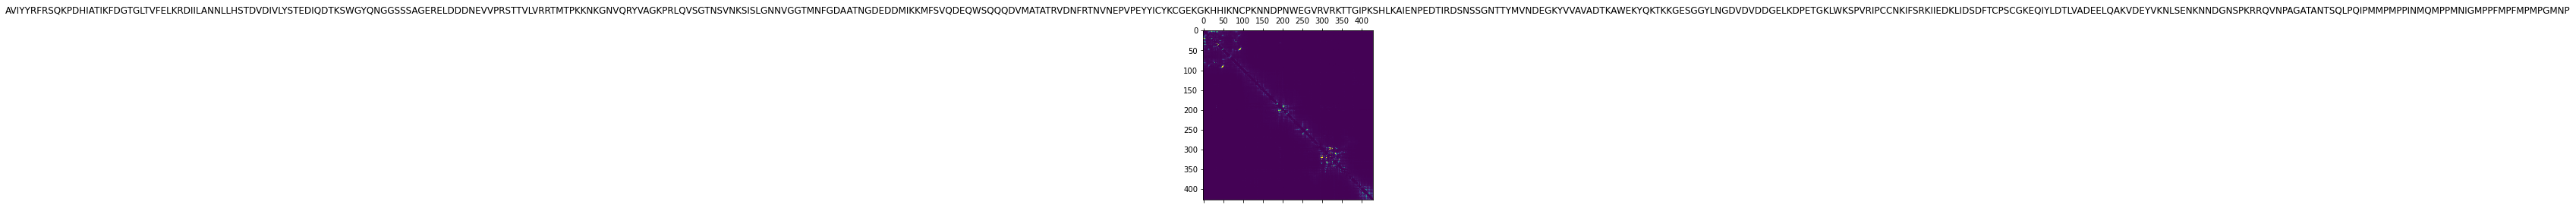

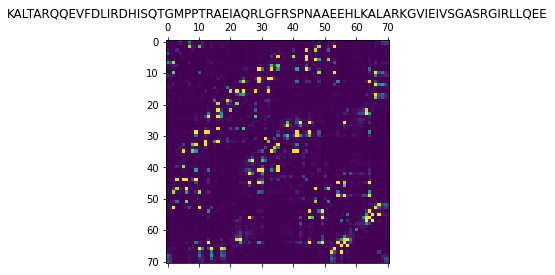

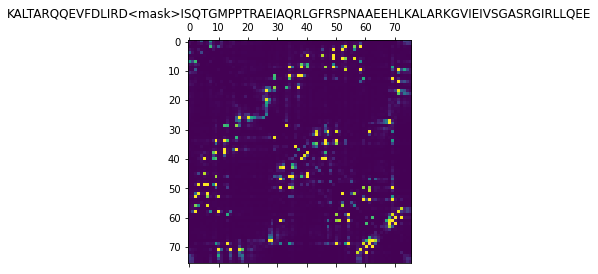

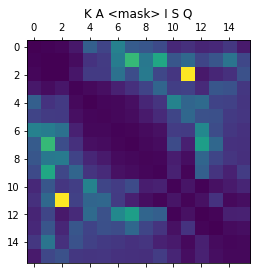

In [100]:
import matplotlib.pyplot as plt
for (_, seq), attention_contacts in zip(data, results["contacts"]):
    plt.matshow(attention_contacts[: len(seq), : len(seq)])
    plt.title(seq)
    plt.show()